In [1]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
from deepxde.callbacks import EarlyStopping
import matplotlib.pyplot as plt

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


## Simplified Quadratic

$
\begin{align}
&  \frac{\partial ^2 y}{\partial s^2}  = 2 \\
y(s=0) = 0 \hspace{1em} & y(s=1) = 1 
\end{align}
$

In [32]:
def pde(s,y):
    return dde.grad.hessian(y,s) - 2

geom = dde.geometry.Interval(0, 1)

def start_bound(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def end_bound(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

def func(s):
    return s**2

bc_start = dde.DirichletBC(geom, lambda x: 0, start_bound)
bc_end = dde.DirichletBC(geom, lambda x:1, end_bound)

data = dde.data.PDE(
    geom,
    pde,
    [bc_start, bc_end],
    num_domain=100,
    num_boundary=30,
    num_test=200,
    solution=func,
    train_distribution='uniform'
)

layer_size = [1] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)
# net.outputs_modify(lambda x, y: x * y)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, loss='MSE',  metrics=["l2 relative error"])
movie = dde.callbacks.MovieDumper(
    "movie_demo_curve", [0], [1], period=100, save_spectrum=True, y_reference=func
)
losshistory, train_state = model.train(epochs=5000, callbacks=[movie])




Compiling model...
Building feed-forward neural network...
'build' took 0.051373 s



/home/syamil/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/syamil/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.780876 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [3.29e+00, 0.00e+00, 2.12e+00]    [3.24e+00, 0.00e+00, 0.00e+00]    [1.61e+00]    
1000      [4.74e-04, 6.37e-08, 2.72e-07]    [4.64e-04, 0.00e+00, 0.00e+00]    [1.17e-03]    
2000      [1.62e-04, 6.85e-09, 2.83e-08]    [1.63e-04, 0.00e+00, 0.00e+00]    [5.04e-04]    
3000      [5.69e-05, 1.06e-04, 3.06e-04]    [4.83e-05, 0.00e+00, 0.00e+00]    [3.16e-02]    
4000      [1.29e-05, 1.81e-09, 3.96e-09]    [1.32e-05, 0.00e+00, 0.00e+00]    [1.35e-04]    
5000      [3.81e-06, 2.05e-12, 5.68e-12]    [4.03e-06, 0.00e+00, 0.00e+00]    [3.65e-05]    

Saving the movie of function to movie_demo_curve_x.txt, movie_demo_curve_y.txt, movie_demo_curve_y.gif...


MovieWriter imagemagick unavailable; using Pillow instead.


Saving the movie of spectrum to movie_demo_curve_spectrum.txt, movie_demo_curve_spectrum.gif...


MovieWriter imagemagick unavailable; using Pillow instead.



Best model at step 5000:
  train loss: 3.81e-06
  test loss: 4.03e-06
  test metric: [3.65e-05]

'train' took 40.026426 s



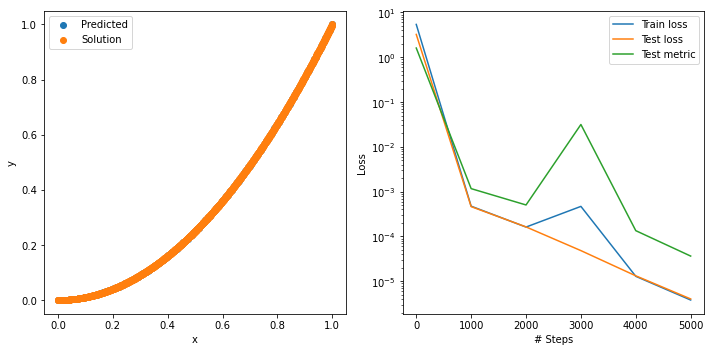

In [34]:
X_train, y_train, X_test, y_test, best_y, best_ystd = train_state.packed_data()
s = geom.uniform_points(1000, True)
z = func(s)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax[0].scatter(X_test.flatten(), best_y.flatten(), label='Predicted')
ax[0].scatter(s, z, label='Solution')
ax[0].set_ylabel("y")
ax[0].set_xlabel("x")
ax[0].legend()

loss_train = np.sum(losshistory.loss_train, axis=1)
loss_test = np.sum(losshistory.loss_test, axis=1)

ax[1].semilogy(losshistory.steps, loss_train, label="Train loss")
ax[1].semilogy(losshistory.steps, loss_test, label="Test loss")
for i in range(len(losshistory.metrics_test[0])):
    ax[1].semilogy(
        losshistory.steps,
        np.array(losshistory.metrics_test)[:, i],
        label="Test metric",
    )
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("# Steps")
ax[1].legend()

fig.tight_layout()